In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import shutil
import random
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

Using TensorFlow backend.


In [27]:
def plot_cm(true,pred):
    cm=confusion_matrix(true,pred)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    ax=sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
    ax.set(xlabel='Prediction', ylabel='Class')
    return ax
#plot_cm(test_ds.classes, test_predict_classes)

# plot train/val accuracy
def plot_accuracy(history):
    ax=plt.figure()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc='lower right')
#plot_accuracy(history)

# evaluate and plot ROC
def plot_roc(y_true, score, return_pos_rate=False):
    fpr, tpr, threshold=roc_curve(y_true,score)
    roc_auc=auc(fpr, tpr)
    ax=plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="best")
    if return_pos_rate==True:
        return ax, pd.DataFrame({'threshold':threshold, 'True Positive Rate':tpr, 'False Positive Rate':fpr})


In [3]:
batch_size = 128
img_height = 224
img_width = 224

dataset1_path_train='/storage/Crack_detection/Dataset1'
dataset1_path_test='/storage/Crack_detection/Dataset1_test'

train_datagen=ImageDataGenerator(
    rescale=1./255,
    validation_split=0.11)

train_ds=train_datagen.flow_from_directory(
    dataset1_path_train,  
    class_mode='binary',
    subset="training", 
    seed=11, 
    target_size=(img_height, img_width), 
    batch_size=batch_size)

val_datagen=ImageDataGenerator(
    rescale=1./255,
    validation_split=0.11)

val_ds=val_datagen.flow_from_directory(
    dataset1_path_train,  
    class_mode='binary',
    subset="validation", 
    seed=11, 
    target_size=(img_height, img_width), 
    batch_size=batch_size)

test_datagen=ImageDataGenerator(rescale=1./255)

test_ds=test_datagen.flow_from_directory(
    dataset1_path_test, 
    class_mode='binary',
    seed=11, 
    target_size=(img_height, img_width), 
    batch_size=batch_size,
    shuffle=False)

Found 32040 images belonging to 2 classes.
Found 3960 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.


## CNN Model 

In [4]:
# model with regularization
model=tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(32, kernel_size=(5,5), strides=(1,1), activation='relu', input_shape=(img_height, img_width, 3)))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
#model.add(tf.keras.layers.Conv2D(64, kernel_size=(5,5), strides=(1,1), activation='relu'))
#model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(100, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.build(input_shape=(img_height, img_width, 3))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 220, 220, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 32)      0         
_________________________________________________________________
flatten (Flatten)            (None, 387200)            0         
_________________________________________________________________
dense (Dense)                (None, 100)               38720100  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 38,722,633
Trainable params: 38,722,633
Non-trainable params: 0
_________________________________________________________________


In [5]:
model.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
             metrics=['accuracy'])

history=model.fit(
    train_ds,
    validation_data=val_ds, 
    epochs=10)

Epoch 1/10
251/251 [==============================] - 469s 2s/step - loss: 1.3916 - accuracy: 0.7889 - val_loss: 0.2023 - val_accuracy: 0.9854
Epoch 2/10
251/251 [==============================] - 462s 2s/step - loss: 0.1765 - accuracy: 0.9775 - val_loss: 0.0713 - val_accuracy: 0.9861
Epoch 3/10
251/251 [==============================] - 452s 2s/step - loss: 0.0829 - accuracy: 0.9777 - val_loss: 0.0453 - val_accuracy: 0.9876
Epoch 4/10
251/251 [==============================] - 517s 2s/step - loss: 0.0604 - accuracy: 0.9809 - val_loss: 0.0542 - val_accuracy: 0.9871
Epoch 5/10
251/251 [==============================] - 452s 2s/step - loss: 0.0444 - accuracy: 0.9878 - val_loss: 0.0414 - val_accuracy: 0.9843
Epoch 6/10
251/251 [==============================] - 462s 2s/step - loss: 0.0353 - accuracy: 0.9893 - val_loss: 0.0651 - val_accuracy: 0.9801
Epoch 7/10
251/251 [==============================] - 599s 2s/step - loss: 0.0233 - accuracy: 0.9937 - val_loss: 0.0433 - val_accuracy: 0.9843

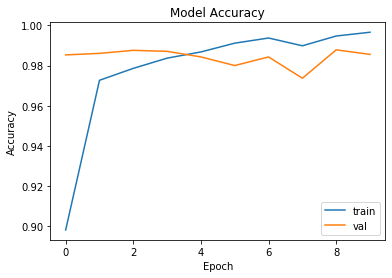

In [28]:
# plot train and val accuracy
plot_accuracy(history)

In [23]:
# prediction and evaluation on test dataset
test_predict=model.predict(test_ds)
test_loss, test_accuracy=model.evaluate(test_ds)
model_accuracy=[np.round(history.history['accuracy'][-1],3), np.round(history.history['val_accuracy'][-1],3), np.round(test_accuracy,3)]    
print(pd.DataFrame({'CNN':model_accuracy}, index=['Train Accuracy', 'Val Accuracy', 'Test Accuracy']))

32/32 [==============================] - 15s 468ms/step - loss: 0.0569 - accuracy: 0.9808
                  CNN
Train Accuracy  0.997
Val Accuracy    0.986
Test Accuracy   0.981


## CNN model w/ dropout regularization

In [14]:
# model with regularization
model_reg=tf.keras.models.Sequential()
model_reg.add(tf.keras.layers.Conv2D(32, kernel_size=(5,5), strides=(1,1), activation='relu', input_shape=(img_height, img_width, 3)))
model_reg.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
#model_reg.add(tf.keras.layers.Conv2D(64, kernel_size=(5,5), strides=(1,1), activation='relu'))
#model_reg.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
model_reg.add(tf.keras.layers.Flatten())
model_reg.add(tf.keras.layers.Dropout(0.2))
model_reg.add(tf.keras.layers.Dense(100, activation='relu'))
model_reg.add(tf.keras.layers.Dropout(0.2))
model_reg.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model_reg.build(input_shape=(img_height, img_width, 3))
model_reg.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 220, 220, 32)      2432      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 110, 110, 32)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 387200)            0         
_________________________________________________________________
dropout (Dropout)            (None, 387200)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               38720100  
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [15]:
model_reg.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
             metrics=['accuracy'])

history_reg=model_reg.fit(
    train_ds,
    validation_data=val_ds, 
    epochs=10)

Epoch 1/10
251/251 [==============================] - 492s 2s/step - loss: 3.0112 - accuracy: 0.7377 - val_loss: 0.1417 - val_accuracy: 0.9843
Epoch 2/10
251/251 [==============================] - 488s 2s/step - loss: 0.1265 - accuracy: 0.9756 - val_loss: 0.0539 - val_accuracy: 0.9912
Epoch 3/10
251/251 [==============================] - 493s 2s/step - loss: 0.0658 - accuracy: 0.9819 - val_loss: 0.0422 - val_accuracy: 0.9904
Epoch 4/10
251/251 [==============================] - 490s 2s/step - loss: 0.0588 - accuracy: 0.9819 - val_loss: 0.0365 - val_accuracy: 0.9917
Epoch 5/10
251/251 [==============================] - 490s 2s/step - loss: 0.0468 - accuracy: 0.9861 - val_loss: 0.0278 - val_accuracy: 0.9924
Epoch 6/10
251/251 [==============================] - 497s 2s/step - loss: 0.0369 - accuracy: 0.9893 - val_loss: 0.0356 - val_accuracy: 0.9881
Epoch 7/10
251/251 [==============================] - 488s 2s/step - loss: 0.0242 - accuracy: 0.9928 - val_loss: 0.0246 - val_accuracy: 0.9907

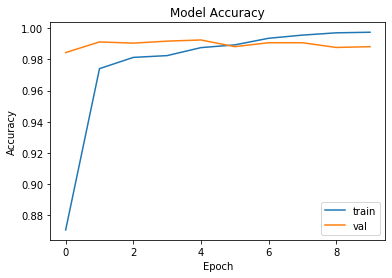

In [29]:
# plot train and val accuracy
plot_accuracy(history_reg)

In [17]:
# prediction and evaluation on test dataset
test_predict_reg=model_reg.predict(test_ds)
test_loss, test_accuracy=model_reg.evaluate(test_ds)
model_reg_accuracy=[np.round(history_reg.history['accuracy'][-1],3), np.round(history_reg.history['val_accuracy'][-1],3), np.round(test_accuracy,3)]    
print(pd.DataFrame({'CNN w/ dropout':model_reg_accuracy}, index=['Train Accuracy', 'Val Accuracy', 'Test Accuracy']))

32/32 [==============================] - 15s 469ms/step - loss: 0.0654 - accuracy: 0.9808
                CNN w/ dropout
Train Accuracy           0.997
Val Accuracy             0.988
Test Accuracy            0.981


In [34]:
# save models and history
model.save('/Crack_detection/Crack_detection/CNN_model_Dataset1_123120.h5') 
model_reg.save('/Crack_detection/Crack_detection/CNN_reg_model_Dataset1_123120.h5') 
hist_df = pd.DataFrame(history.history) 
hist_csv_file = '/Crack_detection/Crack_detection/history_all_img_123120.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)
hist_df = pd.DataFrame(history_reg.history) 
hist_csv_file = '/Crack_detection/Crack_detection/history_dropout_all_img_123120.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

## Model comparison

In [22]:
pd.DataFrame({'CNN':model_accuracy, 'CNN w/ dropout':model_reg_accuracy}, index=['Train Accuracy', 'Val Accuracy', 'Test Accuracy'])

,CNN,CNN w/ dropout
Train Accuracy,0.997,0.997
Val Accuracy,0.986,0.988
Test Accuracy,0.981,0.981


Text(0.5, 1.0, 'Accuracy comparison')

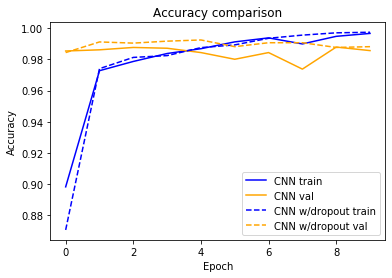

In [33]:
# plot acuracy comparison
plt.figure()
plt.plot(history.history['accuracy'],label='CNN train', c='blue')
plt.plot(history.history['val_accuracy'], label='CNN val', c='orange')
plt.plot(history_reg.history['accuracy'],label='CNN w/dropout train', c='blue', linestyle='--')
plt.plot(history_reg.history['val_accuracy'], label='CNN w/dropout val', c='orange', linestyle='--')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc="best")
plt.title('Accuracy comparison')

Text(0.5, 1, 'CNN model w/ dropout')

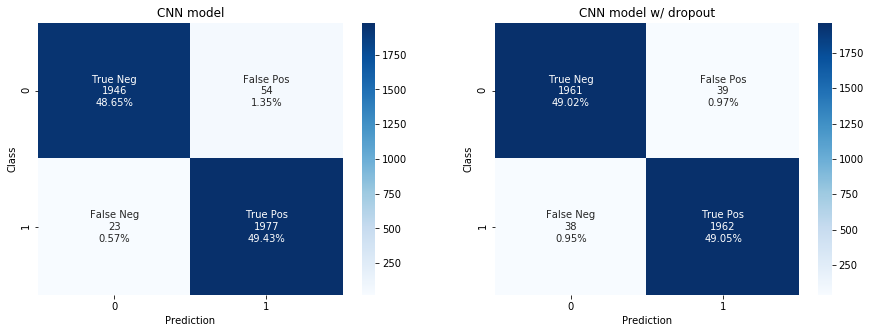

In [19]:
# plot confusion matrix
class_threshold=0.5
test_predict_classes=[1 if i>class_threshold else 0 for i in test_predict]
test_predict_reg_classes=[1 if i>class_threshold else 0 for i in test_predict_reg]
plt.figure(figsize=(15,5))
plt.subplot(121)
plot_cm(test_ds.classes, test_predict_classes)
plt.title('CNN model')
plt.subplot(122)
plot_cm(test_ds.classes, test_predict_reg_classes)
plt.title('CNN model w/ dropout')

Text(0.5, 1.0, 'ROC curve for CNN model w/ dropout')

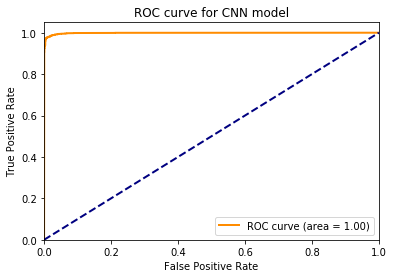

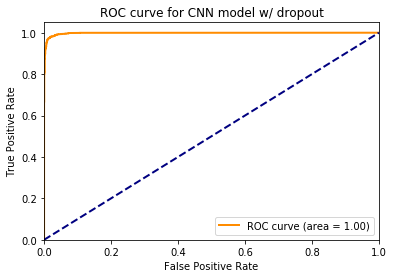

In [32]:
# Plot ROC
ax1=plot_roc(test_ds.classes, test_predict)
plt.title('ROC curve for CNN model')
plot_roc(test_ds.classes, test_predict_reg)
plt.title('ROC curve for CNN model w/ dropout')

## Plot examples of wrong prediction

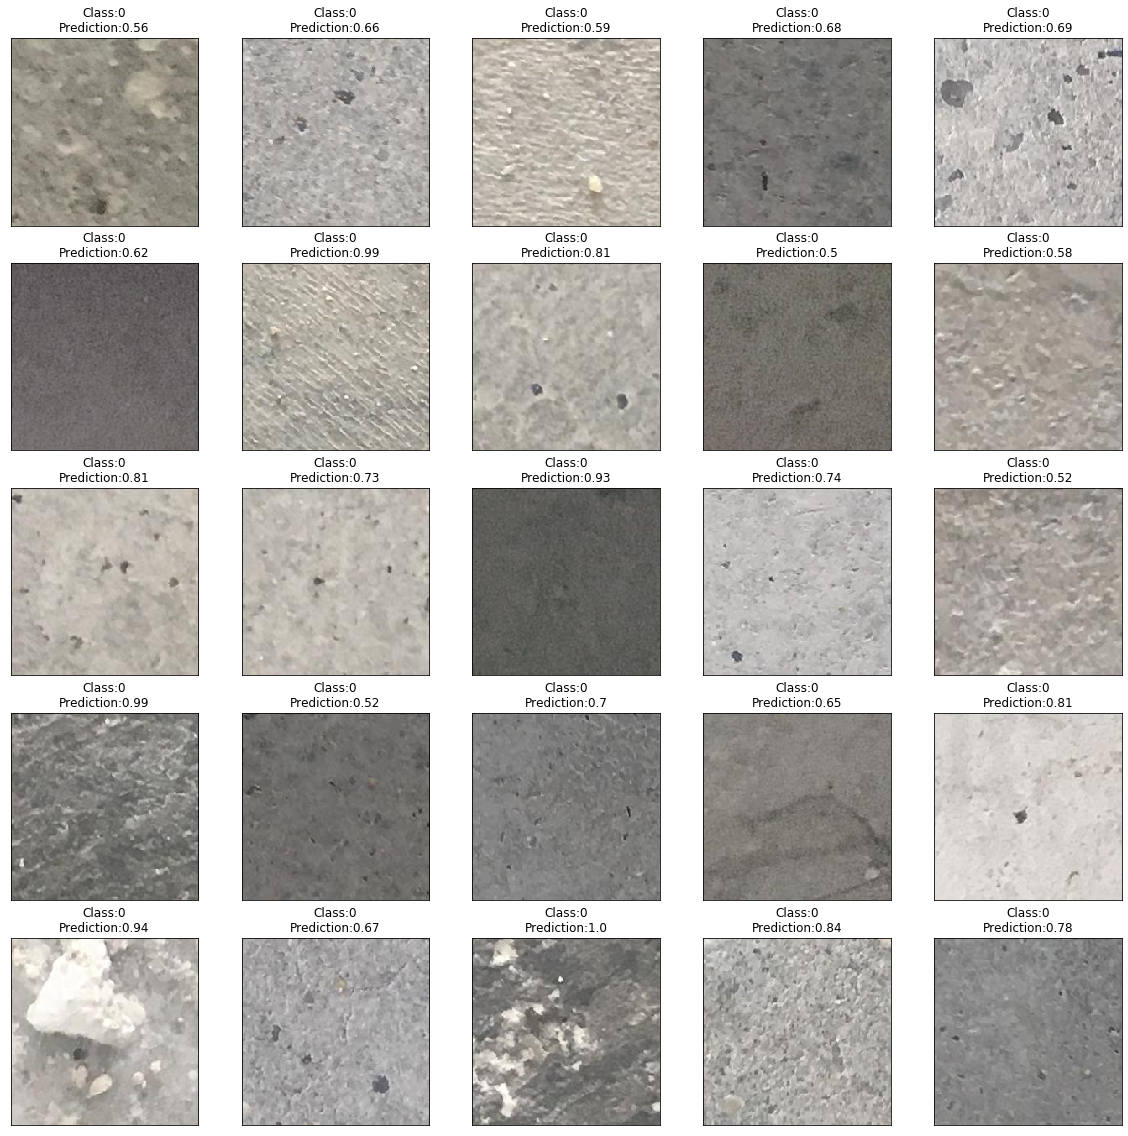

In [14]:
# class 0 wrong prediction 
wrong_prediction_index=[]
for position, value in enumerate(test_predict_classes):
    if value != test_ds.classes[position]:
        wrong_prediction_index.append(position)

img_n_rows=len(wrong_prediction_index)//5+1        
image_idx=0
plt.figure(figsize=(20, 20))
for idx in wrong_prediction_index:
    if image_idx<25:
        image=test_ds[int(idx//batch_size)][0][int((idx/batch_size-idx//batch_size)*batch_size)]
        plt.subplot(5, 5, image_idx + 1)
        plt.imshow(image)
        plt.title('Class:' + str(test_ds.classes[idx]) +'\n'+'Prediction:' + str(np.round(test_predict[idx][0],2)))
        plt.xticks([])
        plt.yticks([])
        image_idx+=1    
plt.show()    

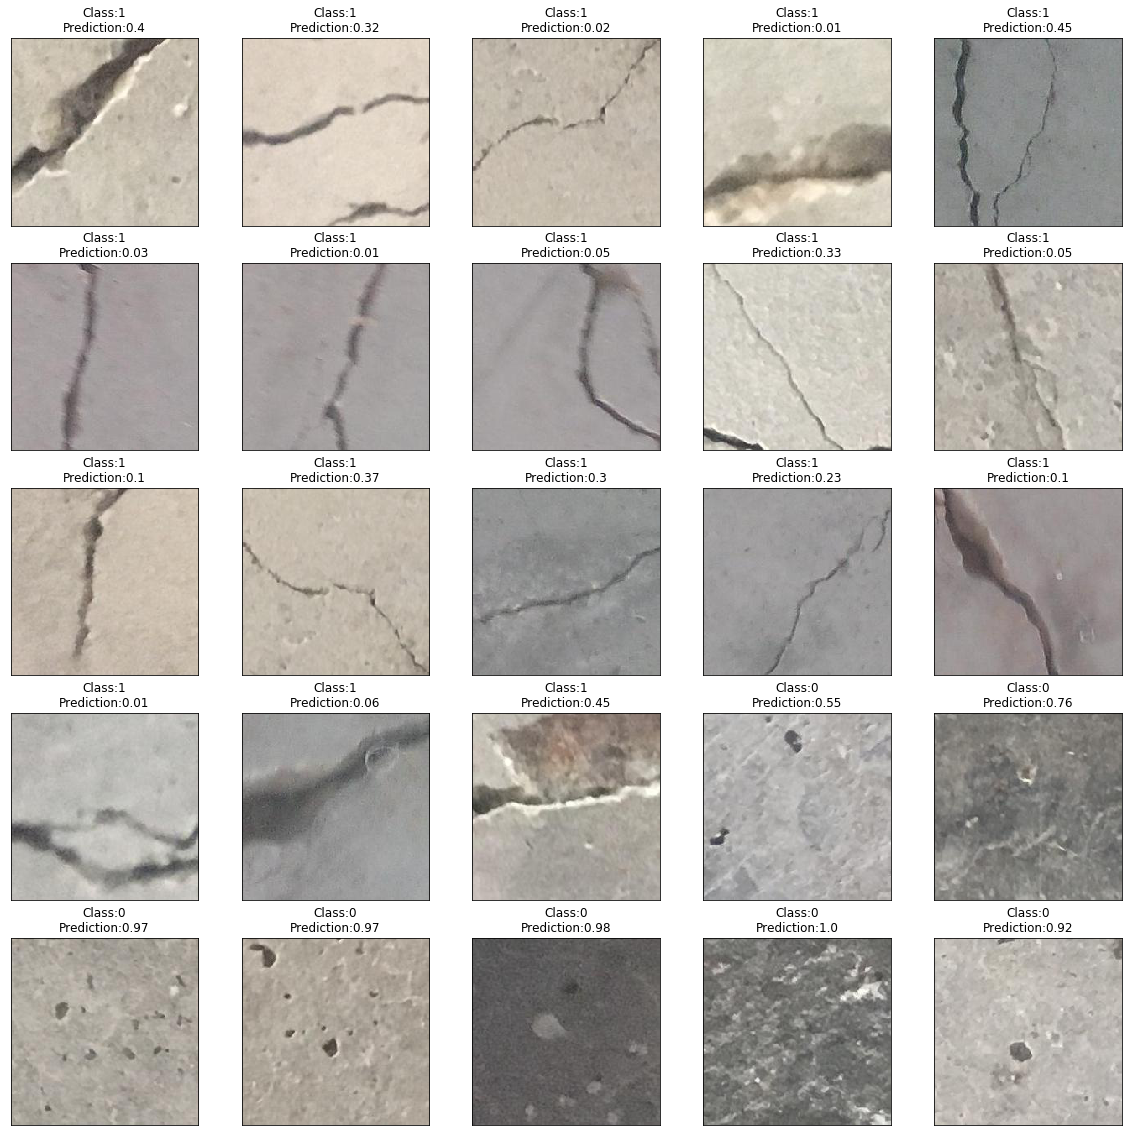

In [16]:
# class 1 wrong prediction 
img_n_rows=len(wrong_prediction_index)//5+1        
image_idx=0
plt.figure(figsize=(20, 20))
wrong_prediction_index.reverse()
for idx in wrong_prediction_index:
    if image_idx<25:
        image=test_ds[int(idx//batch_size)][0][int((idx/batch_size-idx//batch_size)*batch_size)]
        plt.subplot(5, 5, image_idx + 1)
        #plt.subplots(img_n_rows,5, image_idx)
        plt.imshow(image)
        plt.title('Class:' + str(test_ds.classes[idx]) +'\n'+'Prediction:' + str(np.round(test_predict[idx][0],2)))
        plt.xticks([])
        plt.yticks([])
        image_idx+=1    
plt.show()    